In [33]:
# Import everything
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import rangelib
import shapely

# Generate maps that we will use later
FILE_DIR = os.path.dirname(os.path.realpath(os.path.abspath('')))
MAPS_FILE_PATH = os.path.join(FILE_DIR, "maps/tests")

MAP_SIZE = 600  # we want 600x600 square maps

# A corridor-shaped map
corridor_map = np.zeros((MAP_SIZE, MAP_SIZE), dtype=np.uint8)
corridor_map[150:450, :] = 255
CORRIDOR_MAP = os.path.join(MAPS_FILE_PATH, "corridor.png")
Image.fromarray(corridor_map).save(CORRIDOR_MAP)
CORRIDOR_MAP_OBSTACLES = [
    shapely.Polygon([(0, 0), (599, 0), (599, 150), (0, 150)]),
    shapely.Polygon([(0, 450), (599, 450), (599, 599), (0, 599)]),
]

# A map with boxes on all 4 corners
box_map = np.zeros((MAP_SIZE, MAP_SIZE), dtype=np.uint8)
box_map[50:550, 50:550] = 255
BOX_MAP = os.path.join(MAPS_FILE_PATH, "box.png")
Image.fromarray(box_map).save(BOX_MAP)

BOX_MAP_OBSTACLES = [
    shapely.Polygon([(0, 0), (599, 0), (599, 50), (0, 50)]),
    shapely.Polygon([(0, 0), (50, 0), (50, 599), (0, 599)]),
    shapely.Polygon([(0, 550), (599, 550), (599, 599), (0, 599)]),
    shapely.Polygon([(550, 0), (550, 599), (599, 599), (599, 0)]),
]

# A map with a corner
corner_map = np.zeros((MAP_SIZE, MAP_SIZE), dtype=np.uint8)
corner_map[150:450, 150:450] = 255
corner_map[150:450, 0:150] = 255
corner_map[450:, 150:450] = 255
Image.fromarray(corner_map).save(
    os.path.join(MAPS_FILE_PATH, "corner.png"))

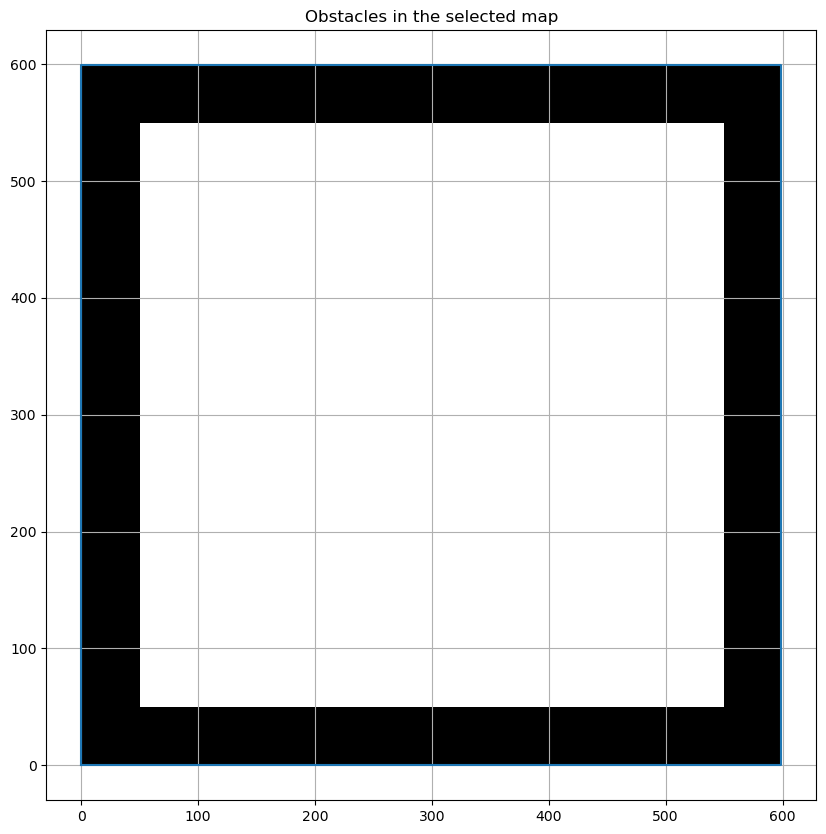

In [34]:
# Define global params
plt.rcParams['figure.figsize'] = [10, 10]

MAX_RANGE_ALL_METHODS = 1000.0

# choose the map
SELECTED_MAP_PATH = BOX_MAP
SELECTED_OBSTACLES = BOX_MAP_OBSTACLES

# Show the obstacles in the map
plt.figure()
plt.title("Obstacles in the selected map")
plt.grid()
for poly in SELECTED_OBSTACLES:
    x, y = poly.exterior.xy
    plt.fill(x, y, "k")
plt.plot((0, 599, 599, 0, 0), (0, 0, 599, 599, 0))  # map borders
plt.gca().set_aspect('equal')
plt.show()

In [35]:
def batchCalcRangeAnglesAnalytic(obstacles, queryPoses, queryAngles):
    '''
    Computes the analytic range between a given set of obstacles and the query poses and 
    angles, akin to the rangelib methods.
    '''
    ret = []
    for pose in queryPoses.transpose():
        for angle in queryAngles:
            # get a line segment to compute intersection with
            p0 = shapely.Point((pose[0], pose[1]))
            dx = np.cos(pose[2] - angle) * 600
            dy = np.sin(pose[2] - angle) * 600
            p1 = shapely.Point((p0.x + dx, p0.y + dy))
            ray = shapely.LineString((p0, p1))

            range = MAX_RANGE_ALL_METHODS

            # Query the closest intersection point
            for obstacle in obstacles:
                intersections: shapely.LineString = ray.intersection(obstacle)
                for intersectionPt in intersections.coords:
                    intersectionRange = np.hypot(p0.x - intersectionPt[0],
                                                 p0.y - intersectionPt[1])

                    if intersectionRange < range:
                        range = intersectionRange

            ret.append(range)

    return np.array(ret, dtype=np.single)

In [36]:
# Setup the range methods
testOMap = rangelib.OMap(SELECTED_MAP_PATH)
testDistanceTransform = rangelib.DistanceTransform(testOMap)
testBresenhams = rangelib.Bresenham(
    testDistanceTransform, MAX_RANGE_ALL_METHODS)
testRayMarching = rangelib.RayMarching(
    testDistanceTransform, MAX_RANGE_ALL_METHODS)
testGiantLookup = rangelib.GiantLUT(
    testDistanceTransform, MAX_RANGE_ALL_METHODS, 180)

In [37]:
# define a grid of particle poses and query angles
queryX = np.linspace(300-100, 300+100, 2, endpoint=True)
queryY = np.linspace(300-100, 300+100, 2, endpoint=True)
queryTheta = np.linspace(0.0, 2*np.pi, 16, endpoint=False)

# make into np array that is acceptable by rangelib
queryList = []
for x in queryX:
    for y in queryY:
        for theta in queryTheta:
            queryList.append((x, y, theta))

queryPoses = np.array(queryList, dtype=np.single).transpose()

# define a grid of query angles
queryAngleTheta = np.linspace(0.0, 2*np.pi, 1, endpoint=False)
queryAngles = np.array(queryAngleTheta, dtype=np.single)

print("Query Poses: ", queryList)
print("Query Angles: ", queryAngles)

analyticResults = batchCalcRangeAnglesAnalytic(
    SELECTED_OBSTACLES, queryPoses, queryAngles)
blResults = testBresenhams.batchCalcRangeAngles(queryPoses, queryAngles)
rmResults = testRayMarching.batchCalcRangeAngles(queryPoses, queryAngles)
gltResults = testGiantLookup.batchCalcRangeAngles(queryPoses, queryAngles)

Query Poses:  [(200.0, 200.0, 0.0), (200.0, 200.0, 0.39269908169872414), (200.0, 200.0, 0.7853981633974483), (200.0, 200.0, 1.1780972450961724), (200.0, 200.0, 1.5707963267948966), (200.0, 200.0, 1.9634954084936207), (200.0, 200.0, 2.356194490192345), (200.0, 200.0, 2.748893571891069), (200.0, 200.0, 3.141592653589793), (200.0, 200.0, 3.5342917352885173), (200.0, 200.0, 3.9269908169872414), (200.0, 200.0, 4.319689898685965), (200.0, 200.0, 4.71238898038469), (200.0, 200.0, 5.105088062083414), (200.0, 200.0, 5.497787143782138), (200.0, 200.0, 5.890486225480862), (200.0, 400.0, 0.0), (200.0, 400.0, 0.39269908169872414), (200.0, 400.0, 0.7853981633974483), (200.0, 400.0, 1.1780972450961724), (200.0, 400.0, 1.5707963267948966), (200.0, 400.0, 1.9634954084936207), (200.0, 400.0, 2.356194490192345), (200.0, 400.0, 2.748893571891069), (200.0, 400.0, 3.141592653589793), (200.0, 400.0, 3.5342917352885173), (200.0, 400.0, 3.9269908169872414), (200.0, 400.0, 4.319689898685965), (200.0, 400.0, 4.7

In [38]:
# parse the results
overallResults = {}

curr_pose_idx = 0
curr_angle_idx = 0
for analytic_res, bl_res, rm_res, glt_res in zip(analyticResults, blResults, rmResults, gltResults):
    curr_pose = queryList[curr_pose_idx]
    curr_angle = queryAngles[curr_angle_idx]
    curr_pose = (curr_pose[0], curr_pose[1], curr_pose[2] - curr_angle)

    if analytic_res < MAX_RANGE_ALL_METHODS:
        overallResults[curr_pose] = (analytic_res, bl_res, rm_res, glt_res)

    if (curr_angle_idx % len(queryAngles) == 0):
        curr_pose_idx += 1
        curr_angle_idx = 0

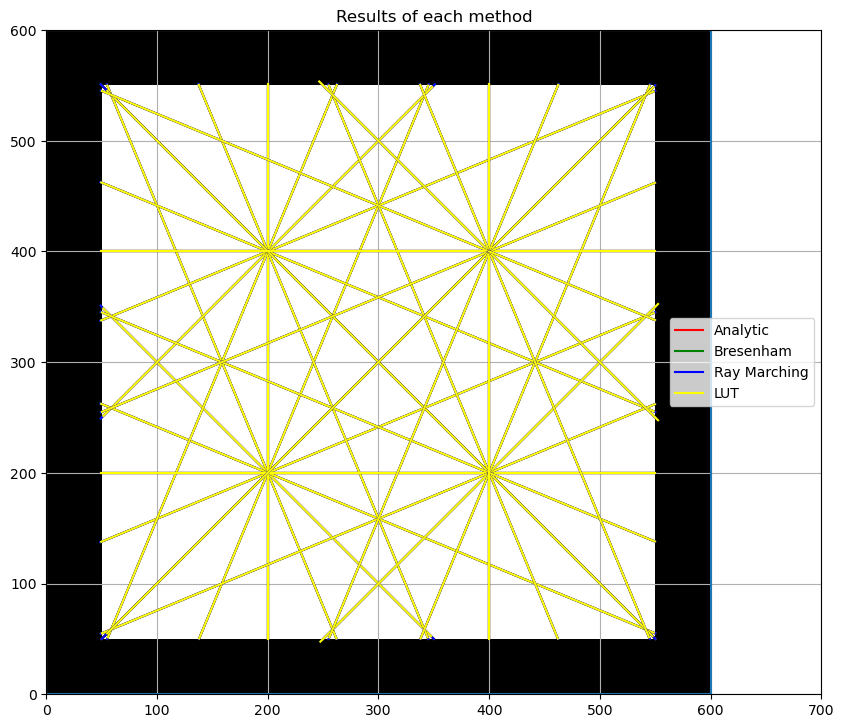

In [39]:
# Plot the results
plt.figure()
plt.title("Results of each method")
plt.grid()
for poly in SELECTED_OBSTACLES:
    x, y = poly.exterior.xy
    plt.fill(x, y, "k")
plt.plot((0, 600, 600, 0, 0), (0, 0, 600, 600, 0))  # map borders

metadata = [
    ('red', "Analytic"),
    ('green', "Bresenham"),
    ('blue', "Ray Marching"),
    ('yellow', "LUT")
]

first = True
for pose, distances in overallResults.items():
    for dist, meta in zip(distances, metadata):
        eff_angle = pose[2]
        dx = np.cos(eff_angle) * dist
        dy = np.sin(eff_angle) * dist
        x = pose[0]
        y = pose[1]

        plt.plot((x, x+dx), (y, y+dy),
                 color=meta[0], label=meta[1] if first else None)
    first = False

plt.legend()
plt.xlim((0, 700))
plt.ylim((0, 600))
plt.gca().set_aspect('equal')
plt.show()

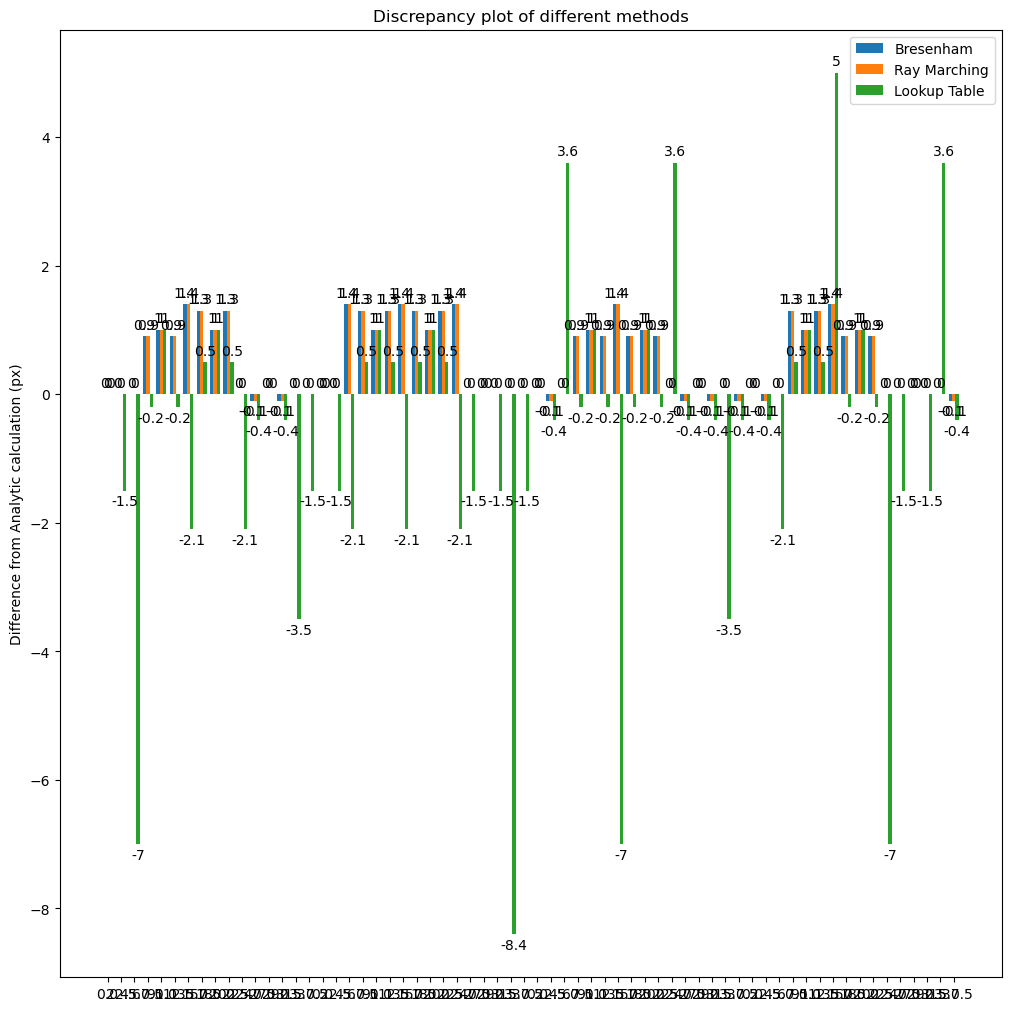

In [40]:
# Plot results for elements with a collision

methods = ("Bresenham", "Ray Marching", "Lookup Table")
nonzero_angles = [np.degrees(pose[2]).round(3) for pose in overallResults.keys()]

discrepancies = {
    'Bresenham': [np.round(range[1]-range[0], 1) for range in overallResults.values()],
    'Ray Marching': [np.round(r[2]-r[0], 1) for r in overallResults.values()],
    'Lookup Table': [np.round(r[3]-r[0], 1) for r in overallResults.values()],
}

x = np.arange(len(nonzero_angles))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in discrepancies.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difference from Analytic calculation (px)')
ax.set_title('Discrepancy plot of different methods')
ax.set_xticks(x + width, nonzero_angles)
ax.legend(loc='upper right')

plt.show()